<hr/>

# **TP CycleGAN : Victor LEDEZ**

<hr/>


> Concernant le projet 1 je vous demande d'entrainer un GAN qui va apprendre a transformer les images de MNIST en image de SVHN. Une fois que vous avez réussi à faire cela je vous laisse vous débrouiller pour réussir à entrainer un CNN pour qu'il puisse marché sur les images du set de test de SVHN tout en ayant aucune annotations pour entrainer sur SVHN. Vous pouvez considérer que vous avez les images de MNIST avec les annotations.


## **Imports**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import os
import sys
from tqdm import tqdm

import random
import numpy as np

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


## **Configs and Utils**


In [2]:
! mkdir -p mnist
! mkdir -p svhn

! wget -O svhn/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
! wget -O svhn/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
! wget -O svhn/extra_32x32.mat http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

A subdirectory or file -p already exists.
Error occurred while processing: -p.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN_MNIST = "genh.pth.tar"
CHECKPOINT_GEN_SVHN = "genz.pth.tar"
CHECKPOINT_CRITIC_MNIST = "critich.pth.tar"
CHECKPOINT_CRITIC_SVHN = "criticz.pth.tar"

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## **Loading Data**


In [ ]:
def get_loader():
    """Builds and returns Dataloader for MNIST and SVHN dataset."""

    transform = transforms.Compose([
        transforms.Scale(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    svhn = datasets.SVHN(root='./svhn',
                         download=True, transform=transform)
    mnist = datasets.MNIST(root='./mnist',
                           download=True, transform=transform)

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=0)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0)
    return svhn_loader, mnist_loader


In [3]:
# loading
train_loader = DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_loader = DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


In [5]:
example_data.shape


torch.Size([1000, 1, 28, 28])

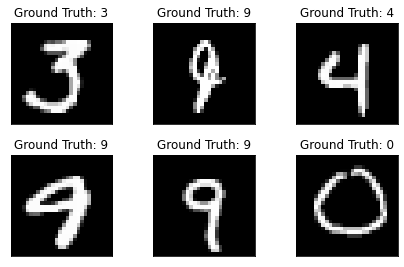

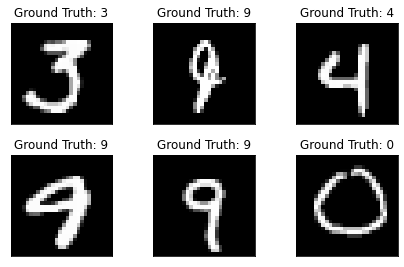

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig


## **Discriminator Model**


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride,
                      1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect'
            ),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature,
                          stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4,
                      stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


## **Generator Model**


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False,
                      kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7,
                      stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True)
        )

        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2,
                          kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4,
                          kernel_size=3, stride=2, padding=1)
            ]
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False,
                          kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features, down=False,
                          kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7,
                              stride=1, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


## **Train**


In [ ]:
def train_fn(disc_MNIST, disc_SVHN, gen_SVHN, gen_MNIST, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    MNIST_reals = 0
    MNIST_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (SVHN, MNIST) in enumerate(loop):
        SVHN = SVHN.to(DEVICE)
        MNIST = MNIST.to(DEVICE)

        # Train Discriminators MNIST and SVHN
        with torch.cuda.amp.autocast():
            fake_MNIST = gen_MNIST(SVHN)
            D_MNIST_real = disc_MNIST(MNIST)
            D_MNIST_fake = disc_MNIST(fake_MNIST.detach())
            MNIST_reals += D_MNIST_real.mean().item()
            MNIST_fakes += D_MNIST_fake.mean().item()
            D_MNIST_real_loss = mse(
                D_MNIST_real, torch.ones_like(D_MNIST_real))
            D_MNIST_fake_loss = mse(
                D_MNIST_fake, torch.zeros_like(D_MNIST_fake))
            D_MNIST_loss = D_MNIST_real_loss + D_MNIST_fake_loss

            fake_SVHN = gen_SVHN(MNIST)
            D_SVHN_real = disc_SVHN(SVHN)
            D_SVHN_fake = disc_SVHN(fake_SVHN.detach())
            D_SVHN_real_loss = mse(D_SVHN_real, torch.ones_like(D_SVHN_real))
            D_SVHN_fake_loss = mse(D_SVHN_fake, torch.zeros_like(D_SVHN_fake))
            D_SVHN_loss = D_SVHN_real_loss + D_SVHN_fake_loss

            # put it together
            D_loss = (D_MNIST_loss + D_SVHN_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators MNIST and SVHN
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_MNIST_fake = disc_MNIST(fake_MNIST)
            D_SVHN_fake = disc_SVHN(fake_SVHN)
            loss_G_MNIST = mse(D_MNIST_fake, torch.ones_like(D_MNIST_fake))
            loss_G_SVHN = mse(D_SVHN_fake, torch.ones_like(D_SVHN_fake))

            # cycle loss
            cycle_SVHN = gen_SVHN(fake_MNIST)
            cycle_MNIST = gen_MNIST(fake_SVHN)
            cycle_SVHN_loss = l1(SVHN, cycle_SVHN)
            cycle_MNIST_loss = l1(MNIST, cycle_MNIST)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_SVHN = gen_SVHN(SVHN)
            identity_MNIST = gen_MNIST(MNIST)
            identity_SVHN_loss = l1(SVHN, identity_SVHN)
            identity_MNIST_loss = l1(MNIST, identity_MNIST)

            # add all together
            G_loss = (
                loss_G_SVHN
                + loss_G_MNIST
                + cycle_SVHN_loss * LAMBDA_CYCLE
                + cycle_MNIST_loss * LAMBDA_CYCLE
                + identity_MNIST_loss * LAMBDA_IDENTITY
                + identity_SVHN_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_MNIST*0.5+0.5, f"saved_images/MNIST_{idx}.png")
            save_image(fake_SVHN*0.5+0.5, f"saved_images/SVHN_{idx}.png")

        loop.set_postfix(MNIST_real=MNIST_reals/(idx+1),
                         MNIST_fake=MNIST_fakes/(idx+1))


disc_MNIST = Discriminator(in_channels=3).to(DEVICE)
disc_SVHN = Discriminator(in_channels=3).to(DEVICE)
gen_SVHN = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_MNIST = Generator(img_channels=3, num_residuals=9).to(DEVICE)
opt_disc = optim.Adam(
    list(disc_MNIST.parameters()) + list(disc_SVHN.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_SVHN.parameters()) + list(gen_MNIST.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN_MNIST, gen_MNIST, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_GEN_SVHN, gen_SVHN, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_MNIST, disc_MNIST, opt_disc, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_SVHN, disc_SVHN, opt_disc, LEARNING_RATE,
    )

dataset = MnistSvhnDataset(
    root_MNIST=TRAIN_DIR+"/MNISTs", root_SVHN=TRAIN_DIR+"/SVHNs", transform=transforms
)
val_dataset = MnistSvhnDataset(
    root_MNIST="cyclegan_test/MNIST1", root_SVHN="cyclegan_test/SVHN1", transform=transforms
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(disc_MNIST, disc_SVHN, gen_SVHN, gen_MNIST, loader,
             opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

    if SAVE_MODEL:
        save_checkpoint(gen_MNIST, opt_gen, filename=CHECKPOINT_GEN_MNIST)
        save_checkpoint(gen_SVHN, opt_gen, filename=CHECKPOINT_GEN_SVHN)
        save_checkpoint(disc_MNIST, opt_disc,
                        filename=CHECKPOINT_CRITIC_MNIST)
        save_checkpoint(disc_SVHN, opt_disc,
                        filename=CHECKPOINT_CRITIC_SVHN)
